## Red Wine Quality 

### Personal Objective:
#### To Familiarise with ML Models and Evaluation techniques


#### Classification Models
#### Binary Classification


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix, classification_report

In [54]:
red_wine = pd.read_csv("redwinequality.csv")

In [3]:
#exploring the dataset
def explore(df):
    print("Shape:", df.shape)
    print("")
    print("First 5 lines")
    print(df.head())
    print("")
    print("Type of data")
    print(df.dtypes)
    print("")
    print("Null values")
    print(df.isnull().sum())
    print("")
    print("Summary")
    print(df.describe())
    
explore(red_wine)

Shape: (1599, 12)

First 5 lines
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.

#### Investigate quality further, we will notice there are only 6 grading in this entire dataset
#### We could (as per suggestion) to classify this whole dataset with good (7 and above) or not good wine (everything else) OR more ambitiously turn this into a multiclass classifcation 

In [4]:
red_wine['quality'].unique()

array([5, 6, 7, 4, 8, 3])

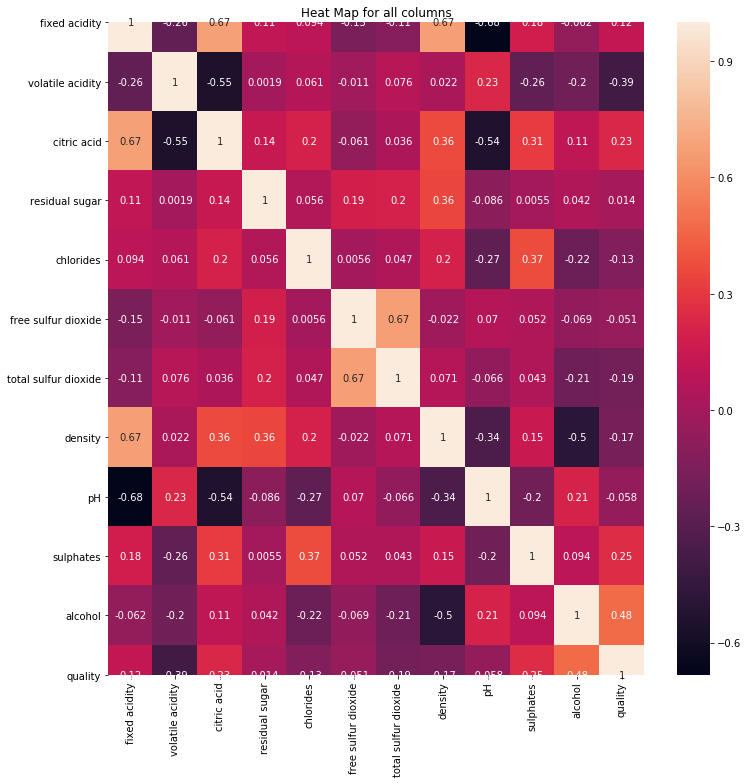

In [5]:
fig, ax = plt.subplots(figsize=(12,12)) 
ax.set_title('Heat Map for all columns')
sns.heatmap(red_wine.corr(), ax = ax, annot=True, annot_kws={"size": 10})
#no major issue on collinearity - except maybe for alcohol content vs quality

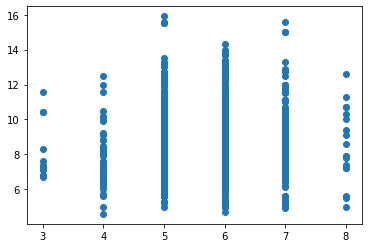

In [6]:
plt.scatter(y='fixed acidity' , x='quality', data=red_wine)

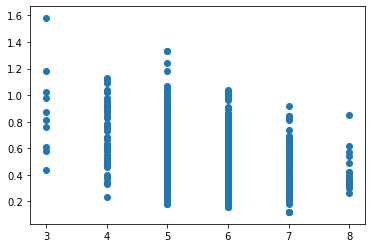

In [7]:
plt.scatter(y='volatile acidity' , x='quality', data=red_wine)

#The good wine usually has lower VA

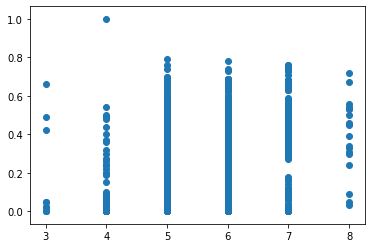

In [8]:
plt.scatter(y='citric acid' , x='quality', data=red_wine)

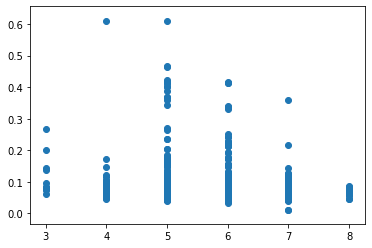

In [9]:
plt.scatter(y='chlorides' , x='quality', data=red_wine)
#really useful in multiclass detection, point 8 has really low chlorides

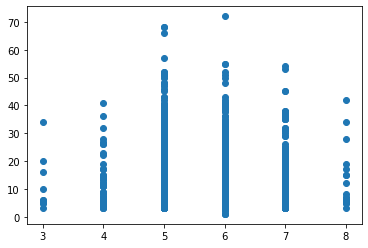

In [10]:
plt.scatter(y='free sulfur dioxide' , x='quality', data=red_wine)

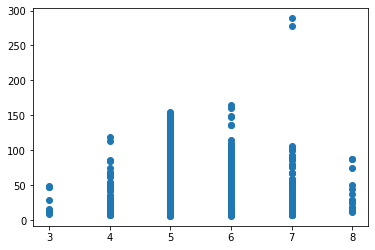

In [11]:
plt.scatter(y='total sulfur dioxide' , x='quality', data=red_wine)
#apart from the 2 outlier, point 7/8 tends to have lower total SO2

(0.99, 1.005)

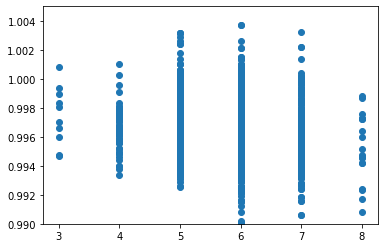

In [12]:
plt.scatter(y='density' , x='quality', data=red_wine)
plt.ylim(0.9900,1.005)

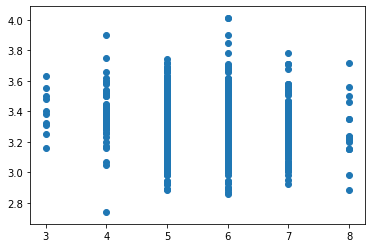

In [13]:
plt.scatter(y='pH' , x='quality', data=red_wine)

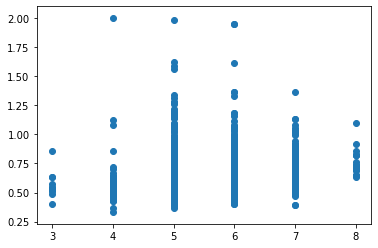

In [14]:
plt.scatter(y='sulphates' , x='quality', data=red_wine)

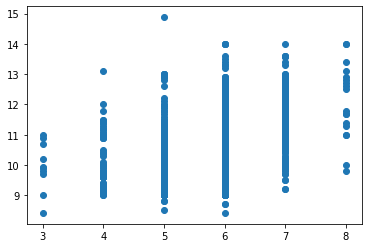

In [15]:
plt.scatter(y='alcohol' , x='quality', data=red_wine)
#the trend tends to move upwards, higher alochol, higher rating

#### Overall, if we were to inspect each variable, it seems like most of them follows normally distributed trend.
#### You could either be a very good wine (7/8 pointer) or lowly rated wine (3/4 pointer)
#### Let's see if our machine learning models can seperate them

In [16]:
red_wine.shape

(1599, 12)

In [17]:
#keeping 10% of our sample as a final validation test
red_wine_valid = red_wine.sample(frac = 0.1, random_state = 12)
red_wine_valid.shape

(160, 12)

In [18]:
#setting up our training dataset
red_wine_training = red_wine.drop(red_wine_valid.index, axis=0)
red_wine_training.shape

(1439, 12)

In [19]:
#setting up our target
y = red_wine_training['quality']
X = red_wine_training.drop('quality',axis=1)

y_valid = red_wine_valid['quality']
X_valid = red_wine_valid.drop('quality',axis=1)

#### We will now transform our scores to:
#### Good wine (Scores 7 and above) to 1 and Not-so-good wines (all other scores) to 0

In [20]:
#counting number of entries for "good wine"
good_wine_count = (y == 7).sum() + (y == 8).sum()
good_wine_count_valid =(y_valid == 7).sum() + (y_valid == 8).sum()

In [21]:
#Transforming our scores of 7 and 8 into "Good wine" == 1 and others into 0
def score(data):
    for i in range(data.shape[0]):
        if data[i] >= 7:
            data[i] = 1
        else:
            data[i] = 0

y_binary = y.reset_index(drop=True)
score(y_binary)

y_binary_valid = y_valid.reset_index(drop=True)
score(y_binary_valid)

In [22]:
#Making sure the function works well for both datasets
print(good_wine_count == (y_binary == 1).sum())
print(good_wine_count_valid == (y_binary_valid == 1).sum())

True
True


In [23]:
#Preprocessing our X columns with standard scaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [24]:
#We will split our data further with using train/test split
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    y_binary,
                                                    random_state=42,
                                                    train_size=0.7)

In [25]:
#Using some old codes from my friends
model = []
parameters = []
scores = []
precision = []
recall = []
roc_auc = []
accuracy = []

# To put the name of model, models from sklearn, and hyperparameters of the model we want to search through in order

names = ['Decision Tree', 'RandomForest', 'LogReg','KNN','SVC','AdaBoost', 'BaggingClass']

estimators = [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression(), KNeighborsClassifier(),
             SVC(), AdaBoostClassifier(), BaggingClassifier()]

params = [
    {'clf__max_depth': [None, 10, 15, 20, 30, 35],
    'clf__min_samples_split': [5,10,15,20,25,30]}, #DecisionTree

    {'clf__max_depth': [None,50,75,100,150,200],
     'clf__min_samples_split': [5,10,15,20,30]}, #RandomForest
    
    {'clf__C':[1,3,5,10],
     'clf__solver':['lbfgs', 'liblinear', 'sag', 'saga'],
     'clf__max_iter':[50,100,125,150,175,200]}, #LogisticRegression
    
    {'clf__n_neighbors':[3,5,10,15,20,25],
     'clf__weights':['uniform','distance'],
     'clf__p':[1,2,3]}, #KNeighborsClassifier
    
    {'clf__kernel':['rbf','sigmoid','poly','linear'],
     'clf__degree':[3,4,5,6]}, #SVC
    
    {'clf__n_estimators':[25,40,50,100,200,500]}, #AdaBoost
    
    {'clf__n_estimators':[10,30,50,100],
     'clf__max_samples':[1,5,10],
     'clf__max_features':[1,5,10]}, #BaggingClassifier
]

for name, estimator, param in zip(names, estimators, params):
    clf_pipe = Pipeline([
        ('clf', estimator)
    ])
    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    gs = GridSearchCV(clf_pipe, param_grid=param, cv=cv, verbose=10, n_jobs=-1)
    gs.fit(X_train, y_train)
    
    print(name)
    print('Best Score: {}'.format(gs.best_score_))
    print('Best Params: {}'.format(gs.best_params_))
    
    # Best Model
    grid_model = gs.best_estimator_
    
    print('Model Score on X_train: {}'.format(grid_model.score(X_train, y_train)))
    
    # Prediction and score
    pred = grid_model.predict(X_test)
    print('Accuracy score of prediction: {}'.format(accuracy_score(y_test, pred)))
    
    
    # Confusion Matrix 
    
    conf_matrix = multilabel_confusion_matrix(y_test, pred, labels=[0,1,2,3,4])
    
    tn = conf_matrix[:, 0, 0]
    tp = conf_matrix[:, 1, 1]
    fn = conf_matrix[:, 1, 0]
    fp = conf_matrix[:, 0, 1]
    
    print('TN: {}, FP:{}, FN:{}, TP:{}'.format(tn,fp,fn,tp))
    print('Precision of the model is {}'.format(np.round(tp/(tp+fp)),2))
    print('Recall of the model is {}'.format(np.round(tp/(tp+fn)),2))
   
    print('\n')
    model.append(name)
    parameters.append(gs.best_params_)
    scores.append(np.round(accuracy_score(y_test, pred),4))
    accuracy.append(np.round((tp+tn)/(tp+fn+fp+tn),4))
    recall.append(np.round(tp/(tp+fn),4))
    precision.append(np.round(tp/(tp+fp),4))
    roc_auc.append(np.round(roc_auc_score(y_test, pred),4))

results = pd.DataFrame({'model': model, 
                        'parameters': parameters,
                        'scores': scores,
                        'accuracy':accuracy,
                        'recall': recall, 
                        'precision': precision,
                        'roc_auc': roc_auc
                       })
results

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1735s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  74 out of 108 | elapsed:    2.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  96 out of 108 | elapsed:    2.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.1s finished
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipyk

Decision Tree
Best Score: 0.8811881188118812
Best Params: {'clf__max_depth': 10, 'clf__min_samples_split': 5}
Model Score on X_train: 0.9821251241310824
Accuracy score of prediction: 0.8217592592592593
TN: [ 24 331 432 432 432], FP:[37 40  0  0  0], FN:[40 37  0  0  0], TP:[331  24   0   0   0]
Precision of the model is [ 1.  0. nan nan nan]
Recall of the model is [ 1.  0. nan nan nan]


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.3s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.01

RandomForest
Best Score: 0.9158415841584159
Best Params: {'clf__max_depth': None, 'clf__min_samples_split': 10}
Model Score on X_train: 0.9632571996027806
Accuracy score of prediction: 0.8888888888888888
TN: [ 29 355 432 432 432], FP:[32 16  0  0  0], FN:[16 32  0  0  0], TP:[355  29   0   0   0]
Precision of the model is [ 1.  1. nan nan nan]
Recall of the model is [ 1.  0. nan nan nan]


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done 120 out of 288 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:    0.4s finished
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0190s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done   8 out of 108 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  19 out of 1

LogReg
Best Score: 0.900990099009901
Best Params: {'clf__C': 1, 'clf__max_iter': 50, 'clf__solver': 'lbfgs'}
Model Score on X_train: 0.8937437934458788
Accuracy score of prediction: 0.8726851851851852
TN: [ 20 357 432 432 432], FP:[41 14  0  0  0], FN:[14 41  0  0  0], TP:[357  20   0   0   0]
Precision of the model is [ 1.  1. nan nan nan]
Recall of the model is [ 1.  0. nan nan nan]


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.5s finished
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0180s.) Setting batch_size=22.


KNN
Best Score: 0.9174917491749175
Best Params: {'clf__n_neighbors': 5, 'clf__p': 3, 'clf__weights': 'distance'}
Model Score on X_train: 1.0
Accuracy score of prediction: 0.8703703703703703
TN: [ 30 346 432 432 432], FP:[31 25  0  0  0], FN:[25 31  0  0  0], TP:[346  30   0   0   0]
Precision of the model is [ 1.  1. nan nan nan]
Recall of the model is [ 1.  0. nan nan nan]


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done   5 out of  48 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  48 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  15 out of  48 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  48 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.3s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipy

SVC
Best Score: 0.8976897689768977
Best Params: {'clf__degree': 3, 'clf__kernel': 'rbf'}
Model Score on X_train: 0.9126117179741807
Accuracy score of prediction: 0.875
TN: [ 19 359 432 432 432], FP:[42 12  0  0  0], FN:[12 42  0  0  0], TP:[359  19   0   0   0]
Precision of the model is [ 1.  1. nan nan nan]
Recall of the model is [ 1.  0. nan nan nan]


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.9s finished


AdaBoost
Best Score: 0.9026402640264026
Best Params: {'clf__n_estimators': 200}
Model Score on X_train: 0.974180734856008
Accuracy score of prediction: 0.8634259259259259
TN: [ 25 348 432 432 432], FP:[36 23  0  0  0], FN:[23 36  0  0  0], TP:[348  25   0   0   0]
Precision of the model is [ 1.  1. nan nan nan]
Recall of the model is [ 1.  0. nan nan nan]


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0190s.) Setting batch_size=20.
[Parallel(n_jobs=-1)]: Done   8 out of 108 | elapsed:    0.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  19 out of 108 | elapsed:    0.2s remaining:    1.0s


BaggingClass
Best Score: 0.8679867986798679
Best Params: {'clf__max_features': 5, 'clf__max_samples': 5, 'clf__n_estimators': 10}
Model Score on X_train: 0.8669314796425025
Accuracy score of prediction: 0.8587962962962963
TN: [  0 371 432 432 432], FP:[61  0  0  0  0], FN:[ 0 61  0  0  0], TP:[371   0   0   0   0]
Precision of the model is [ 1. nan nan nan nan]
Recall of the model is [ 1.  0. nan nan nan]




[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.4s finished
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide


,model,parameters,scores,accuracy,recall,precision,roc_auc
0,Decision Tree,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.8218,"[0.8218, 0.8218, 1.0, 1.0, 1.0]","[0.8922, 0.3934, nan, nan, nan]","[0.8995, 0.375, nan, nan, nan]",0.6428
1,RandomForest,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.8889,"[0.8889, 0.8889, 1.0, 1.0, 1.0]","[0.9569, 0.4754, nan, nan, nan]","[0.9173, 0.6444, nan, nan, nan]",0.7161
2,LogReg,"{'clf__C': 1, 'clf__max_iter': 50, 'clf__solve...",0.8727,"[0.8727, 0.8727, 1.0, 1.0, 1.0]","[0.9623, 0.3279, nan, nan, nan]","[0.897, 0.5882, nan, nan, nan]",0.6451
3,KNN,"{'clf__n_neighbors': 5, 'clf__p': 3, 'clf__wei...",0.8704,"[0.8704, 0.8704, 1.0, 1.0, 1.0]","[0.9326, 0.4918, nan, nan, nan]","[0.9178, 0.5455, nan, nan, nan]",0.7122
4,SVC,"{'clf__degree': 3, 'clf__kernel': 'rbf'}",0.8750,"[0.875, 0.875, 1.0, 1.0, 1.0]","[0.9677, 0.3115, nan, nan, nan]","[0.8953, 0.6129, nan, nan, nan]",0.6396
5,AdaBoost,{'clf__n_estimators': 200},0.8634,"[0.8634, 0.8634, 1.0, 1.0, 1.0]","[0.938, 0.4098, nan, nan, nan]","[0.9062, 0.5208, nan, nan, nan]",0.6739
6,BaggingClass,"{'clf__max_features': 5, 'clf__max_samples': 5...",0.8588,"[0.8588, 0.8588, 1.0, 1.0, 1.0]","[1.0, 0.0, nan, nan, nan]","[0.8588, nan, nan, nan, nan]",0.5000


In [26]:
#We will use RF since it has the best score in our training data
#Best Params: {'clf__max_depth': 75, 'clf__min_samples_split': 15}

rf_model = RandomForestClassifier(max_depth=75,min_samples_split=15)
rf_model.fit(X,y_binary)
rf_model.score(X,y_binary)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9562195969423211

In [27]:
pred = rf_model.predict(X_valid)
conf_matrix_result = confusion_matrix(y_binary_valid, pred)
conf_matrix_result

array([[133,   5],
       [ 18,   4]])

In [28]:
tn = conf_matrix_result[0, 0]
tp = conf_matrix_result[1, 1]
fn = conf_matrix_result[1, 0]
fp = conf_matrix_result[0, 1]

accuracy = np.round((tp+tn)/(tp+fn+fp+tn),4)
print(accuracy)

0.8562


#### Trying out Keras, CNN

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [30]:
model = Sequential()
model.add(Dense(32, activation="relu", dtype='float64'))
model.add(Dense(16, activation="relu",dtype='float64'))
model.add(Dense(8, activation="relu",dtype='float64'))
model.add(Dense(1, activation='sigmoid', dtype='float64'))

In [31]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [32]:
model.fit(
    X_train,y_train,
    batch_size=32,
    epochs=50,
    validation_data= (X_test, y_test))

Epoch 1/50
32/32 [==============================] - 0s 6ms/step - loss: 0.5704 - accuracy: 0.8173 - val_loss: 0.4903 - val_accuracy: 0.8588
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.4070 - accuracy: 0.8669 - val_loss: 0.3918 - val_accuracy: 0.8588
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.3256 - accuracy: 0.8669 - val_loss: 0.3631 - val_accuracy: 0.8588
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.2962 - accuracy: 0.8669 - val_loss: 0.3453 - val_accuracy: 0.8588
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.2807 - accuracy: 0.8669 - val_loss: 0.3351 - val_accuracy: 0.8588
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.2703 - accuracy: 0.8669 - val_loss: 0.3304 - val_accuracy: 0.8588
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.2637 - accuracy: 0.8669 - val_loss: 0.3292 - val_accuracy: 0.8588
Epoch 8/50
32/32 [==

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  384       
_________________________________________________________________
dense_1 (Dense)              multiple                  528       
_________________________________________________________________
dense_2 (Dense)              multiple                  136       
_________________________________________________________________
dense_3 (Dense)              multiple                  9         
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
_________________________________________________________________


In [34]:
predictions_cnn = model.predict(X_valid)
predictions_cnn[3][0]

0.00012678956470183104

In [35]:
def transform(data):
    for i in range(data.shape[0]):
        if data[i][0] >= 0.5:
            data[i][0] = 1
        else:
            data[i][0] = 0

transform(predictions_cnn)

In [36]:
conf_matrix_result_2 = confusion_matrix(y_binary_valid, predictions_cnn)
conf_matrix_result_2

array([[138,   0],
       [ 22,   0]])

In [37]:
tn = conf_matrix_result_2[0, 0]
tp = conf_matrix_result_2[1, 1]
fn = conf_matrix_result_2[1, 0]
fp = conf_matrix_result_2[0, 1]

accuracy = np.round((tp+tn)/(tp+fn+fp+tn),4)
print(accuracy)
#close enough for a simplified cnn

0.8625
